In [9]:
import pandas as pd

matches = pd.read_csv("atp_matches_2020.csv")
atp_players = pd.read_csv("atp_players.csv")
atp_rankings_10s = pd.read_csv("atp_rankings_current.csv")

year = 2020
matches_file_name = "atp_matches_2020_cleaned.csv"
output_gz_path = "graph2020.gz"
output_gml_path = "graph2020.gml"

In [10]:
import networkx as nx

import collections
from collections import Counter

import matplotlib
from matplotlib import pyplot as plt

import math

from networkx.algorithms import community as comm
import itertools

from operator import itemgetter

import string

import numpy as np

from sklearn import cluster

import copy

# Ciscenje podataka

## Brisanje grupnih turnira

In [11]:
matches = matches[['tourney_id','tourney_name','winner_id','loser_id','surface']]

indexes=[]
for index,tourney_id,tourney_name,winner_id,loser_id,surface in matches.itertuples():
    if ("Davis Cup" in tourney_name):
        indexes.append(index)        
        
matches = matches.drop(indexes)  

In [12]:
from datetime import date

def get_num_of_days_between(start_date_int,end_date_int):
    start_date = date(int(start_date_int/10000), int(int(start_date_int%10000)/100), int(start_date_int%100))
    end_date = date(int(end_date_int/10000), int(int(end_date_int%10000)/100), int(end_date_int%100))
    difference = end_date - start_date
    return difference.days

def get_player_ranking(id,year):
    next_year=(year+1)*10000
    year*=10000
    ranks = atp_rankings_10s[(atp_rankings_10s['player']==id) & (atp_rankings_10s['ranking_date']>=year) & (atp_rankings_10s['ranking_date']<next_year)]
    ranks=ranks.reset_index()
    days_sum=0
    calc_rank=0
    for i in range(len(ranks)-1):
        rank = ranks.loc[i,'rank']
        start_date = ranks.loc[i,'ranking_date']
        end_date = ranks.loc[i+1,'ranking_date']
        days = get_num_of_days_between(start_date,end_date)
        calc_rank += rank*days
        days_sum +=days   
    return calc_rank/days_sum if days_sum != 0 else float('NaN')

In [13]:
winners = set(matches['winner_id'].unique())
losers = set(matches['loser_id'].unique())

players_ids = winners.union(losers)
print(f"Postoji { len(players_ids) } različitih igrača") 

players_with_attr_list = [(player_id,first_name+' '+last_name,country_code,get_player_ranking(player_id,year)) for _,player_id,first_name,last_name,hand,birth_date,country_code in atp_players.itertuples() if player_id in players_ids]
players_with_attr = pd.DataFrame(players_with_attr_list,columns =['player_id', 'player_name','country_code','rank'])

players = (players_with_attr.set_index('player_id')).to_dict('index')
#players = players.set_index('player_id')
#players = pd.DataFrame.from_dict(players_with_attr.set_index('player_id').to_dict('index'),orient='index')

Postoji 244 različitih igrača


## Cuvanje sekundarnog skupa podataka

In [14]:
matches.to_csv(matches_file_name, index = False, header=True)
#pd.DataFrame.from_dict(players,orient='index').to_csv(players_file_name, index = True, header=True)

# Modelovanje grafova

In [15]:
G = nx.Graph()
G.add_nodes_from(players_ids)

nx.set_node_attributes(G, players)

### Dodavanje tezinskih grana 

In [16]:
edge_data = matches[['winner_id','loser_id']]
for _,winner_id,loser_id in edge_data.itertuples():
    if (winner_id, loser_id) in G.edges:
        G.edges[winner_id, loser_id]['weight'] += 1
    else:
        G.add_edge(winner_id, loser_id, weight=1)
        
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 244
Number of edges: 1216
Average degree:   9.9672


## Pomocni graf turnira 

In [17]:
tourney_graph = nx.Graph()

tourney_graph.add_nodes_from(players_ids, node_type='player')
nx.set_node_attributes(tourney_graph, players)

tourney_names = matches['tourney_name'].unique()
tourney_graph.add_nodes_from(tourney_names, node_type='tourney')  

## Dodavanje tezinskih grana 

In [18]:
edge_data = matches[['winner_id','loser_id','tourney_name']]
for _,winner_id,loser_id,tourney_name in edge_data.itertuples():
    if (winner_id, tourney_name) in tourney_graph.edges:
        tourney_graph.edges[winner_id, tourney_name]['weight'] += 1
    else:
        tourney_graph.add_edge(winner_id, tourney_name, weight=1)
    if (loser_id, tourney_name) in tourney_graph.edges:
        tourney_graph.edges[loser_id, tourney_name]['weight'] += 1
    else:
        tourney_graph.add_edge(loser_id, tourney_name, weight=1)  
        
print(nx.info(tourney_graph))

Name: 
Type: Graph
Number of nodes: 277
Number of edges: 1340
Average degree:   9.6751


## Surface atribut

In [19]:
tourney_nodes = [node for node, node_type in tourney_graph.nodes(data='node_type') if node_type=='tourney']

for tourney in tourney_nodes:
    tourney_graph.nodes[tourney]['surface'] = matches[matches['tourney_name']==tourney].iloc[0].surface

# Pomocne metode (uz modelovan graf)

In [20]:
def get_player_by_name(player_name):
    nodes = [node for node,name in G.nodes(data='player_name') if name==player_name]
    player = 0
    if len(nodes)>0:
        player = nodes[0]
    return player

def get_players_matches(id):
    mask = (matches['winner_id']==id) | (matches['loser_id']==id)
    return matches[mask]

In [21]:
def get_nodes_by_attribute(G,attribute, value):
    return [n for n,v in G.nodes(data=True) if v[attribute] == value]

In [22]:
def get_players_degrees(G,players):
    return [(node,name,G.degree(node)) for (node,name) in tourney_graph.nodes(data='player_name') if node in players]

In [23]:
def get_player_attribute(G,player,attribute):
    return [v[attribute] for n,v in G.nodes(data=True) if  n== player]

In [24]:
def get_player_info(id):
    return (id,G.nodes[id]['player_name'],G.nodes[id]['rank'],G.nodes[id]['country_code'])
    #return tuple([(node,attr['player_name'],attr['rank'],attr['country_code']) for (node,attr) in G.nodes(data=True) if node==id])

def get_players_info(players):
    infos = []
    for player in players:
        infos.append(get_player_info(player))
    return infos  

In [25]:
def get_players_opponents_info(id):
    opponents = nx.node_connected_component(G, id)
    return get_players_info(opponents)

In [26]:
def plot_deg_frequency(G, weighted=False, xscale = "log", yscale = "log"):

    if weighted:
        degrees = G.degree(weight="weight")
    else:
        degrees = G.degree()
    _, deg_list = zip(*degrees)    #unzip
    deg_counts = Counter(deg_list) #prebrojava, 1, 2, ..        
    print(deg_counts)
    degree, frequency = zip(*deg_counts.items())                                                      

    plt.figure(1)   

    # prep axes   
    if weighted:
        plt.xlabel('weighted degree')  
    else:
        plt.xlabel('degree')                                                                                                             
    plt.xscale(xscale)                                                                                                                
    plt.xlim(1, max(degree))  

    plt.ylabel('frequency')                                                                                                          
    plt.yscale(yscale)                                                                                                                
    plt.ylim(1, max(frequency))                                                                                                             
                                                                                                                                                                                                    
    plt.scatter(degree, frequency, marker='.')                                                                                                    
    plt.show()

# Istrazivacka pitanja

# 1. Koliki je prosečan broj tenisera (saigrača) po svakom teniseru?

In [27]:
def get_average_degree(G):
    num_of_nodes = G.number_of_nodes()
    degree = sum(d for n, d in G.degree()) / float(num_of_nodes)
    return degree

def get_average_weighted_degree(G):
    num_of_nodes = G.number_of_nodes()
    degree = sum(d for n, d in G.degree(weight='weight')) / float(num_of_nodes)
    return degree  

In [28]:
print(f"Prosecan broj saigraca svakog tenisera: {get_average_degree(G)}")   

Prosecan broj saigraca svakog tenisera: 9.967213114754099


In [29]:
print(f"Prosecan broj meceva svakog tenisera: {get_average_weighted_degree(G)}")

Prosecan broj meceva svakog tenisera: 10.967213114754099


# 2. Koji teniseri su se susretali sa najvećim brojem drugih tenisera? 

In [30]:
degrees = [G.degree(node) for node in G.nodes()]
max_degree = max(degrees)

players_degrees = [(node,name,G.degree(node)) for (node,name) in G.nodes(data='player_name')]

high_degree_players = (sorted(players_degrees, key=lambda element: (element[2]),reverse=True))[:10]

print(f"Max stepen: {max_degree}")
print(f"Igraci koji su igrali sa najvise drugih igraca: {high_degree_players}")

Max stepen: 43
Igraci koji su igrali sa najvise drugih igraca: [(126094, 'Andrey Rublev', 43), (200000, 'Felix Auger Aliassime', 37), (104925, 'Novak Djokovic', 32), (126774, 'Stefanos Tsitsipas', 32), (111575, 'Karen Khachanov', 31), (106043, 'Diego Sebastian Schwartzman', 30), (134770, 'Casper Ruud', 30), (106421, 'Daniil Medvedev', 30), (100644, 'Alexander Zverev', 29), (104745, 'Rafael Nadal', 29)]


# 3. Koji teniseri su učestvovali na najvećem broju (različitih) turnira?

In [31]:
player_tourney_degrees = [(node,name,tourney_graph.degree(node)) for (node,name) in tourney_graph.nodes(data='player_name') if node in players]

high_tourney_degree_players = (sorted(player_tourney_degrees, key=lambda element: (element[2]),reverse=True))[:10]

print(f"Igraci koji su ucestvovali na najvecem broju turnira: {high_tourney_degree_players}")

Igraci koji su ucestvovali na najvecem broju turnira: [(200000, 'Felix Auger Aliassime', 17), (105173, 'Adrian Mannarino', 17), (122330, 'Alexander Bublik', 16), (105526, 'Jan Lennard Struff', 15), (105583, 'Dusan Lajovic', 15), (105357, 'John Millman', 15), (128034, 'Hubert Hurkacz', 14), (105554, 'Daniel Evans', 14), (126094, 'Andrey Rublev', 14), (132283, 'Lorenzo Sonego', 14)]


In [32]:
[(p[1],(p[2])) for p in high_degree_players]

[('Andrey Rublev', 43),
 ('Felix Auger Aliassime', 37),
 ('Novak Djokovic', 32),
 ('Stefanos Tsitsipas', 32),
 ('Karen Khachanov', 31),
 ('Diego Sebastian Schwartzman', 30),
 ('Casper Ruud', 30),
 ('Daniil Medvedev', 30),
 ('Alexander Zverev', 29),
 ('Rafael Nadal', 29)]

# 4. Koji teniseri su dobri kandidati za predstavnike profesionalnih tenisera? 
## Da li i šta se menja ukoliko se umesto jednog bira skup od nekoliko predstavnika?
### Dobar predstavnik ili predstavnici bi trebalo da budu u kontaktu sa što većim skupom tenisera.

In [33]:
#Mozda po lokalnoj centralnosti? - Čvor je lokalno centralan ako ima veći broj veza sa svojim okruženjem
degree_centralities = [(node, centrality) for node, centrality in nx.degree_centrality(G).items()]

max_degree_centralities = sorted(degree_centralities,key=lambda item: item[1], reverse=True)[:10]

high_degree_centrality_players = [(get_player_info(player[0]), player[1]) for player in max_degree_centralities]

print(f"Dobri kandidati za predstavnika profesionalnih tenisera su")
high_degree_centrality_players

Dobri kandidati za predstavnika profesionalnih tenisera su


[((126094, 'Andrey Rublev', 13.1, 'RUS'), 0.1769547325102881),
 ((200000, 'Felix Auger Aliassime', 20.5, 'CAN'), 0.1522633744855967),
 ((104925, 'Novak Djokovic', 1.08, 'SRB'), 0.13168724279835392),
 ((126774, 'Stefanos Tsitsipas', 5.94, 'GRE'), 0.13168724279835392),
 ((111575, 'Karen Khachanov', 16.26, 'RUS'), 0.12757201646090535),
 ((106043, 'Diego Sebastian Schwartzman', 12.36, 'ARG'), 0.1234567901234568),
 ((134770, 'Casper Ruud', 34.98, 'NOR'), 0.1234567901234568),
 ((106421, 'Daniil Medvedev', 4.88, 'RUS'), 0.1234567901234568),
 ((100644, 'Alexander Zverev', 7.0, 'GER'), 0.11934156378600824),
 ((104745, 'Rafael Nadal', 1.92, 'ESP'), 0.11934156378600824)]

In [34]:
#Eigenvector centrality - Varijanta centralnosti po stepenu koja uzima u obzir i susedstvo posmatranog čvora
#onaj sa najvecom plus njegovi susedi??
eigenvector_centralities = [(node, centrality) for node, centrality in nx.eigenvector_centrality(G).items()]

#prvih 10
max_eigenvector_centralities = sorted(eigenvector_centralities,key=lambda item: item[1], reverse=True)[:10]

high_eigenvector_centrality_players = [(get_player_info(player[0]), player[1]) for player in max_eigenvector_centralities]

print(f"Dobri kandidati za predstavnika profesionalnih tenisera su")
high_eigenvector_centrality_players

Dobri kandidati za predstavnika profesionalnih tenisera su


[((126094, 'Andrey Rublev', 13.1, 'RUS'), 0.21798648241096658),
 ((126774, 'Stefanos Tsitsipas', 5.94, 'GRE'), 0.18271880093477258),
 ((200000, 'Felix Auger Aliassime', 20.5, 'CAN'), 0.1807990619061916),
 ((100644, 'Alexander Zverev', 7.0, 'GER'), 0.1645022685926327),
 ((104925, 'Novak Djokovic', 1.08, 'SRB'), 0.15992274181622335),
 ((104745, 'Rafael Nadal', 1.92, 'ESP'), 0.15331849718347088),
 ((106421, 'Daniil Medvedev', 4.88, 'RUS'), 0.1530226056073477),
 ((106043, 'Diego Sebastian Schwartzman', 12.36, 'ARG'), 0.1519374789988706),
 ((133430, 'Denis Shapovalov', 14.64, 'CAN'), 0.13800299915851497),
 ((122330, 'Alexander Bublik', 51.54, 'KAZ'), 0.1375268311773595)]

# 5. Kako su rangirani na ATP listi teniseri koji su se susretali sa najvećim brojem drugih tenisera?

In [35]:
high_degree_players_ids = list(list(zip(*high_degree_players))[0])

high_degree_players_ranks = [(node,attr['player_name'],G.degree(node),attr['rank']) for (node,attr) in G.nodes(data=True) if node in high_degree_players_ids]
high_degree_players_ranks = sorted(high_degree_players_ranks,key=lambda item: item[3])
high_degree_players_ranks

[(104925, 'Novak Djokovic', 32, 1.08),
 (104745, 'Rafael Nadal', 29, 1.92),
 (106421, 'Daniil Medvedev', 30, 4.88),
 (126774, 'Stefanos Tsitsipas', 32, 5.94),
 (100644, 'Alexander Zverev', 29, 7.0),
 (106043, 'Diego Sebastian Schwartzman', 30, 12.36),
 (126094, 'Andrey Rublev', 43, 13.1),
 (111575, 'Karen Khachanov', 31, 16.26),
 (200000, 'Felix Auger Aliassime', 37, 20.5),
 (134770, 'Casper Ruud', 30, 34.98)]

# 6.  Iz kojih zemalja dolazi najveći broj aktivnih igrača u proteklom periodu?

In [36]:
def plot_players_per_country_frequency(G, xscale = "linear", yscale = "linear"):

    countries = [country for node,country in G.nodes(data='country_code')]
    countries_counts = Counter(countries) #prebrojava, 1, 2, ..        
    print(countries_counts)
    lists = sorted(countries_counts.items(),key=lambda item: item[1])
    x, y = zip(*lists)                                                      

    fig = plt.figure(1) 
    fig.set_size_inches(20,20)
    plt.barh(x,y)
    #plt.ylabel('Country')
    plt.xlabel('Број играча')
    plt.show()

Counter({'USA': 26, 'FRA': 22, 'ITA': 18, 'ESP': 14, 'AUS': 14, 'ARG': 13, 'GER': 12, 'RUS': 9, 'SRB': 8, 'JPN': 7, 'CAN': 6, 'GBR': 5, 'SVK': 5, 'IND': 5, 'AUT': 4, 'SUI': 4, 'CZE': 4, 'CRO': 4, 'CHI': 4, 'BEL': 4, 'POL': 3, 'URU': 3, 'UKR': 3, 'KAZ': 3, 'BUL': 3, 'BRA': 3, 'POR': 3, 'RSA': 2, 'NOR': 2, 'HUN': 2, 'NED': 2, 'GEO': 2, 'BLR': 2, 'MDA': 2, 'TPE': 2, 'LTU': 1, 'EGY': 1, 'MEX': 1, 'SWE': 1, 'UZB': 1, 'ECU': 1, 'BIH': 1, 'NZL': 1, 'TUR': 1, 'FIN': 1, 'BOL': 1, 'LAT': 1, 'PER': 1, 'GRE': 1, 'TUN': 1, 'COL': 1, 'CYP': 1, 'SLO': 1, 'KOR': 1})


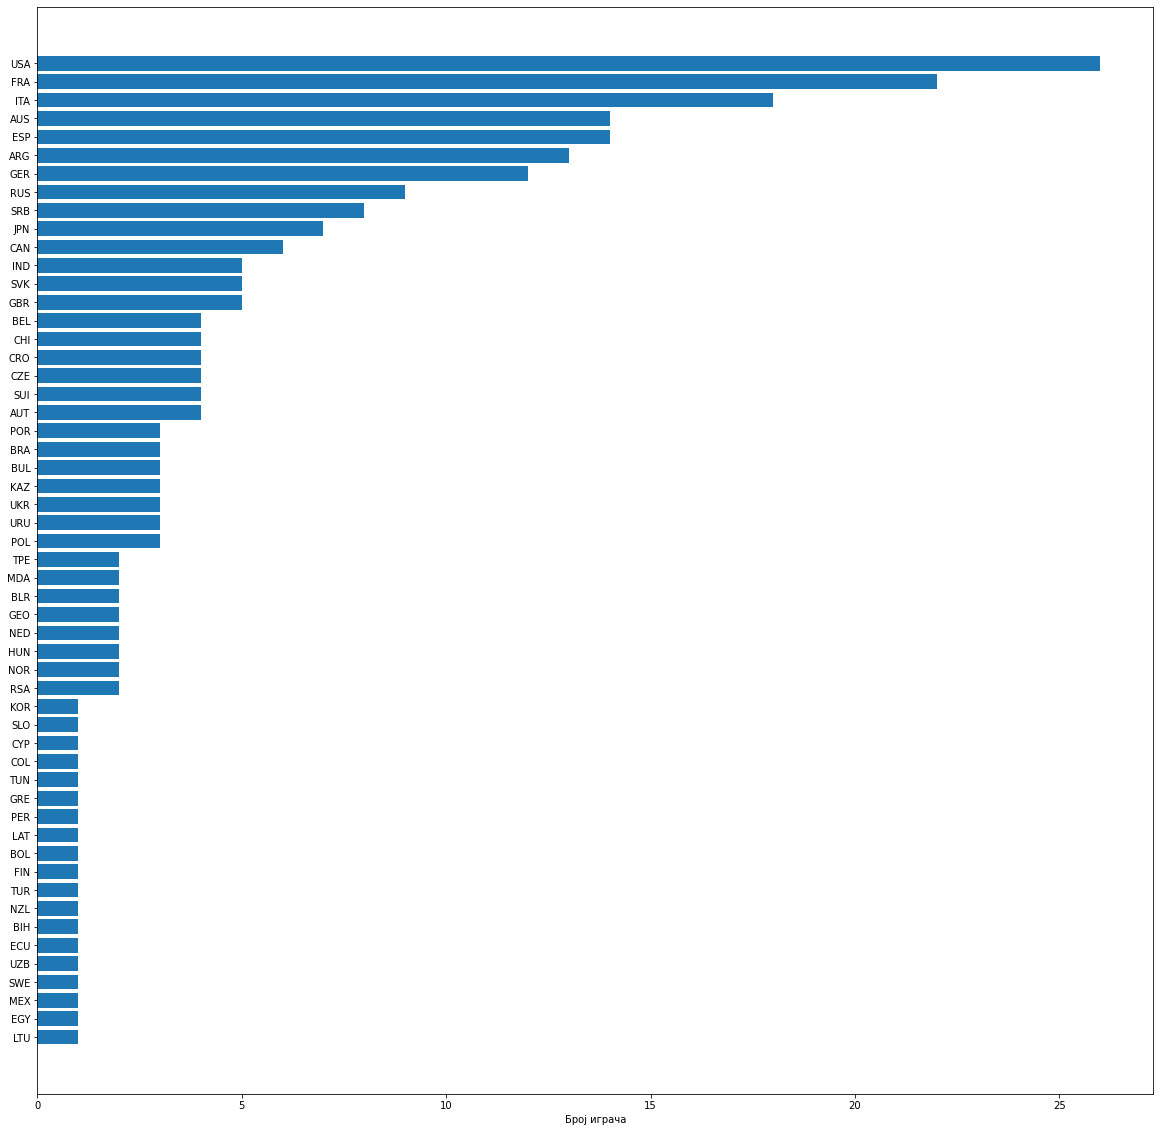

In [37]:
plot_players_per_country_frequency(G)

# 7. Iz kojih zemalja dolaze najuspešniji igrači u smislu osvojenih poena na ATP listi?

In [38]:
def get_first_atp_players(num):
    player_ranks = [(node,attr['player_name'],attr['rank'],attr['country_code']) for (node,attr) in G.nodes(data=True)]

    player_ranks = (list(filter(lambda x: math.isnan(x[2])==False, player_ranks)))
    player_ranks = (sorted(player_ranks, key=lambda element: (element[2]),reverse=False))[:num]
    return player_ranks
    

In [39]:
def plot_best_players_per_country_frequency(countries, xscale = "linear", yscale = "linear"):
    countries_counts = Counter(countries) #prebrojava, 1, 2, ..        
    print(countries_counts)
    lists = sorted(countries_counts.items(),key=lambda item: item[1])
    x, y = zip(*lists)                                                    

    fig = plt.figure(1) 
    fig.set_size_inches(20,20)
    plt.barh(x,y)
    plt.ylabel('Country')
    plt.xlabel('num of players')
    plt.show()

In [40]:
countries = get_first_atp_players(100)
_,_,_,countries = zip(*countries)

#za USA se dosta vidi razlika u 100 i 1000
#ali se pitanje odnosi na najuspesnije
#plot_best_players_per_country_frequency(countries)

# 8. Kako su u okviru skupa podataka okarakterisani igrači iz Srbije?

In [41]:
serbian_players = [player for player,country in G.nodes(data='country_code') if country=='SRB']

serbian_players_ranks = [(get_player_info(player)[1],rank) for player,rank in G.nodes(data='rank') if player in serbian_players]
print(f"Po ranku srpski igraci su: {serbian_players_ranks}\n")

serbian_players_matches = [(get_player_info(player)[1],degree) for player,degree in G.degree(weight='weight') if player in serbian_players]
print(f"Po broju meceva srpski igraci su: {serbian_players_matches}\n")

serbian_players_opponents = [(get_player_info(player)[1],degree) for player,degree in G.degree() if player in serbian_players]
print(f"Po broju saigraca srpski igraci su: {serbian_players_opponents}\n")


#Mozda u odnos na druge zemlje?

Po ranku srpski igraci su: [('Dusan Lajovic', 24.18), ('Nikola Milojevic', 143.88), ('Viktor Troicki', 184.72), ('Danilo Petrovic', 155.2), ('Filip Krajinovic', 32.34), ('Novak Djokovic', 1.08), ('Miomir Kecmanovic', 46.72), ('Laslo Djere', 68.88)]

Po broju meceva srpski igraci su: [('Dusan Lajovic', 30), ('Nikola Milojevic', 4), ('Viktor Troicki', 4), ('Danilo Petrovic', 4), ('Filip Krajinovic', 28), ('Novak Djokovic', 46), ('Miomir Kecmanovic', 29), ('Laslo Djere', 22)]

Po broju saigraca srpski igraci su: [('Dusan Lajovic', 27), ('Nikola Milojevic', 4), ('Viktor Troicki', 4), ('Danilo Petrovic', 4), ('Filip Krajinovic', 24), ('Novak Djokovic', 32), ('Miomir Kecmanovic', 26), ('Laslo Djere', 19)]



# 9. Koje zajednice (komune) se mogu uočiti prilikom analize mreže? Da li postoji neko objašnjenje za detektovane komune?

In [42]:
#Clauset-Newman-Moore pohlepni algoritam
communities = comm.greedy_modularity_communities(G, weight='weight')
communities = [list(community) for community in communities]

# communities_info = {}
# i=0
# for community in communities:
#     i+=1
#     communities_info[i] = get_players_info(community)

communities_info = {}
for i in range(0,len(communities)):
    communities_info[i+1] = get_players_info(communities[i])
    
#communities_info

# 10. Sprovesti analizu klasterisanja i asortativnu analizu, pa uporediti grupisanje na osnovu zemlje iz koje igrači dolaze, na osnovu broja mečeva koje igraju i na osnovu rejtinga.

# Analiza klasterisanja

In [43]:
#Lokalni koeficijent klasterizacije
#računa se kao gustina mreže koju čine posmatrani čvor, njegovi susedi i njihove međusobne veze

player_id, clustering_coef = zip(*nx.clustering(G, weight = "weight").items())

not_zero_cc_players = [(get_player_info(player),cc,degree[1])  for player, cc, degree in zip(player_id, clustering_coef, G.degree(weight='weight')) if cc > 0]
not_zero_cc_players = (sorted(not_zero_cc_players, key=lambda element: (element[1]),reverse=True))

max_local_clustering_coef = max(clustering_coef)

average_clustering_coef = nx.average_clustering(G)

print(f"Max lokalni cc: {max_local_clustering_coef}")
print(f"Prosečan cc: {average_clustering_coef}")
print("Lokalni stepeni klasterisanja koji nisu nula:")
#not_zero_cc_players

Max lokalni cc: 0.36221344998831934
Prosečan cc: 0.13330185391836785
Lokalni stepeni klasterisanja koji nisu nula:


## Asortativnost 

In [44]:
# asortativnost na osnovu netežinskog stepena čvora
graph_ass = nx.degree_assortativity_coefficient(G)
print(f"Koeficijent asortativnosti na osnovu netežinskog stepena čvora: {graph_ass}")

# asortativnost na osnovu težinskog stepena čvora
graph_weighted_ass = nx.degree_assortativity_coefficient(G, weight='weight')
print(f"Koeficijent asortativnosti na osnovu težinskog stepena cvora (broja meceva): {graph_weighted_ass}")

#Umereno asortativna mreza? - vezivanje cvorova koji su slicni

# asortativnost na osnovu ranka
graph_rank_ass = nx.attribute_assortativity_coefficient(G, 'rank')
print(f"Koeficijent asortativnosti na osnovu ranka čvora: {graph_rank_ass}")

#U grupe??

Koeficijent asortativnosti na osnovu netežinskog stepena čvora: 0.11071575805786592
Koeficijent asortativnosti na osnovu težinskog stepena cvora (broja meceva): 0.12841410730839986
Koeficijent asortativnosti na osnovu ranka čvora: -0.007852032804048161


In [45]:
max_rank = max([rank for (node,rank) in G.nodes(data='rank')])

def getRankGroup(rank):
    if rank<100:
        return 'group100'
    if rank<250:
        return 'group250'
    if rank<500:
        return 'group500'
    if rank<2000:
        return 'group2000'
    return 'theLastGroup'

def addRankGroupAttributes():
    for player in players:
        G.nodes[player]['rank_group']=getRankGroup(G.nodes[player]['rank'])

In [46]:
addRankGroupAttributes()

graph_rank_group_ass = nx.attribute_assortativity_coefficient(G, 'rank_group')
print(f"Koeficijent asortativnosti na osnovu kategorije ranka čvora: {graph_rank_group_ass}")

Koeficijent asortativnosti na osnovu kategorije ranka čvora: 0.037315187488652854


In [47]:
# asortativnost na osnovu drzave
graph_rank_ass = nx.attribute_assortativity_coefficient(G, 'country_code')
print(f"Koeficijent asortativnosti na osnovu drzave: {graph_rank_ass}")

Koeficijent asortativnosti na osnovu drzave: 0.00515365175018384


# 11. U kojoj meri teniseri imaju tendenciju da se susreću sa istim teniserima? Da li na to utiče njihovo rangiranje na ATP listi?


In [48]:
def plot_num_of_opponents_per_rank(G, xscale = "linear", yscale = "linear"):
     
    x=[]
    y=[]
    for node,rank in G.nodes(data='rank'):
        x.append(G.degree(weight='weight')[node]/G.degree[node])
        y.append(rank)

    plt.xscale(xscale)                                                                                                                
    #plt.xlim(1, max(x))  
    plt.xlim(1, 2)  

    plt.ylabel('rank')  
    plt.xlabel('broj meceva/broj protivnika') 
    plt.yscale(yscale)                                                                                                                
    plt.ylim(1, max(y))  
                                                                                                                                                                                                    
    plt.scatter(x, y, marker='.')                                                                                                    
    plt.show()

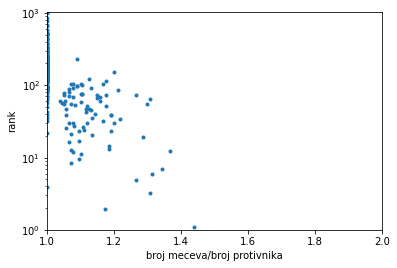

In [49]:
plot_num_of_opponents_per_rank(G,'linear','log')

# 12. Koji teniseri predstavljaju jezgro mreže?


In [50]:
from networkx.algorithms import core

core_graph = core.k_core(G)

print(nx.info(core_graph))

#da li je 78 od 219 jezgro?
core_nodes = [(node,name) for node,name in core_graph.nodes(data='player_name')]

#gustina znatno veca!
nx.density(core_graph)

Name: 
Type: Graph
Number of nodes: 74
Number of edges: 605
Average degree:  16.3514


0.2239911144020733

# 13. Ko su teniseri koji povezuju različite grupe u okviru mreže?

In [51]:
betweenness_centralities = [(node, centrality) for node, centrality in nx.betweenness_centrality(G).items()]

max_betweenness_centralities = sorted(betweenness_centralities,key=lambda item: item[1], reverse=True)[:10]

high_betweenness_centralities_centrality_players = [(get_player_info(player[0]), player[1]) for player in max_betweenness_centralities]

print(f"Teniseri koji povezuju različite grupe u okviru mreže")
high_betweenness_centralities_centrality_players

Teniseri koji povezuju različite grupe u okviru mreže


[((126094, 'Andrey Rublev', 13.1, 'RUS'), 0.04531402898058733),
 ((111575, 'Karen Khachanov', 16.26, 'RUS'), 0.039075276037771736),
 ((106233, 'Dominic Thiem', 3.22, 'AUT'), 0.0366178405588593),
 ((200000, 'Felix Auger Aliassime', 20.5, 'CAN'), 0.03637337335165794),
 ((105138, 'Roberto Bautista Agut', 11.8, 'ESP'), 0.03560043620634105),
 ((134770, 'Casper Ruud', 34.98, 'NOR'), 0.035424912231427914),
 ((104925, 'Novak Djokovic', 1.08, 'SRB'), 0.035237697363032144),
 ((200005, 'Ugo Humbert', 40.58, 'FRA'), 0.03503216727699918),
 ((105683, 'Milos Raonic', 26.5, 'CAN'), 0.0338794424384867),
 ((111815, 'Cameron Norrie', 72.46, 'GBR'), 0.03289995422910655)]

# 14. Kolika je gustina svake od modelovanih mreža?

In [52]:
nx.density(G)

0.04101733792079876

# 15. U kojoj meri su mreže povezane i centralizovane?

In [53]:
_,degrees = zip(*G.degree())

N=len(degrees)
max_degree = max(degrees)

#sum(max(x)-x)/(length(x)-1)
centralization = float((N*max_degree - sum(degrees)))/(N-1)**2

centralization

0.1364968077359481

In [54]:
def plot_players_per_centralities_frequency(G, xscale = "linear", yscale = "linear"):

    degree_centralities = [centrality for node, centrality in nx.degree_centrality(G).items()]
    centralities_counts = Counter(degree_centralities) #prebrojava, 1, 2, ..        
    print(centralities_counts)
    #lists = sorted(centralities_counts.items(),key=lambda item: item[1])
    x,frequency = zip(*centralities_counts.items())                                                      

    fig = plt.figure(1) 
    plt.xlabel('degree centrality')  
    plt.xscale(xscale)                                                                                                                
    plt.xlim(0, max(x))  

    plt.ylabel('frequency')                                                                                                          
    plt.yscale(yscale)                                                                                                                
    plt.ylim(1, max(frequency))                                                                                                             
                                                                                                                                                                                                    
    plt.scatter(x, frequency, marker='.')  
    plt.show()   

Counter({0.00411522633744856: 48, 0.00823045267489712: 27, 0.01234567901234568: 18, 0.020576131687242802: 13, 0.01646090534979424: 13, 0.08230452674897121: 10, 0.02469135802469136: 10, 0.0617283950617284: 8, 0.10699588477366256: 8, 0.02880658436213992: 8, 0.07818930041152264: 7, 0.05761316872427984: 6, 0.041152263374485604: 6, 0.06995884773662552: 5, 0.08641975308641976: 5, 0.03292181069958848: 5, 0.09465020576131689: 4, 0.102880658436214: 4, 0.05349794238683128: 4, 0.04526748971193416: 4, 0.03703703703703704: 4, 0.11111111111111112: 3, 0.11522633744855967: 3, 0.07407407407407408: 3, 0.06584362139917696: 3, 0.1234567901234568: 3, 0.04938271604938272: 2, 0.11934156378600824: 2, 0.09876543209876544: 2, 0.13168724279835392: 2, 0.09053497942386832: 1, 0.1769547325102881: 1, 0.1522633744855967: 1, 0.12757201646090535: 1})


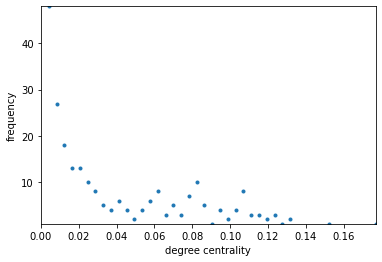

In [55]:
#ako ima nekoliko koji se izdvajaju sa velikom centralnoscu - centralizovan
#nas nije
plot_players_per_centralities_frequency(G)

In [56]:
# returns number of nodes to be removed 
# so that Graph becomes disconnected 
print(nx.node_connectivity(G)) 
  
# returns number of edges to be removed 
# so that Graph becomes disconnected 
print(nx.edge_connectivity(G))

#treba mnogo vremena!!!
#nx.average_node_connectivity(G)

1
1


# 16. Koje su prosečne distance, a koliki dijametar u okviru modelovanih mreža?

In [57]:
#ovoga vise nema kad smo izbacili Davis Cup!
# for g in [G.subgraph(c) for c in nx.connected_components(G)]: 
#     if len(g.nodes())<=4:
#         small_components=get_players_info(g.nodes())
#     if len(g.nodes())==19:
#         one_bigger_component=getPlayersInfo(g.nodes())
        
if nx.is_connected(G):
    print(f'Prosecna distanca: {(nx.average_shortest_path_length(G))}')
    print(f'Dijametar: {nx.diameter(G)}')

Prosecna distanca: 2.844026175538015
Dijametar: 6


# 17. Kakva je distribucija čvorova po stepenu i da li prati neku zakonomernost? Kako je stepen čvora korelisan sa rejtingom tenisera?

Counter({1: 48, 2: 27, 3: 18, 5: 13, 4: 13, 20: 10, 6: 10, 15: 8, 26: 8, 7: 8, 19: 7, 14: 6, 10: 6, 17: 5, 21: 5, 8: 5, 23: 4, 25: 4, 13: 4, 11: 4, 9: 4, 27: 3, 28: 3, 18: 3, 16: 3, 30: 3, 12: 2, 29: 2, 24: 2, 32: 2, 22: 1, 43: 1, 37: 1, 31: 1})


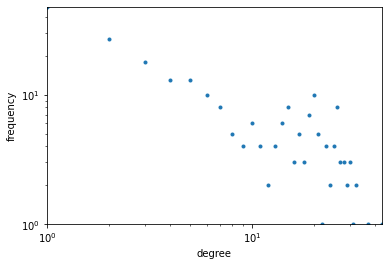

In [58]:
plot_deg_frequency(G, weighted=False)

In [59]:
def plot_deg_distribution(G, weighted=False, xscale = "log", yscale = "log"):

    if weighted:
        degrees = G.degree(weight="weight")
    else:
        degrees = G.degree()
    _, deg_list = zip(*degrees)    #unzip
    deg_counts = Counter(deg_list) #prebrojava, 1, 2, ..        
    print(deg_counts)
    degree, frequency = zip(*deg_counts.items())                                                      

    fig = plt.figure(1)
    plt.ylabel('degree')
    plt.ylabel('Broj cvorova')
    ax = fig.add_axes([0,0,1,1])
    ax.bar(degree,frequency)
    plt.show()

Counter({1: 48, 2: 27, 3: 18, 5: 13, 4: 13, 20: 10, 6: 10, 15: 8, 26: 8, 7: 8, 19: 7, 14: 6, 10: 6, 17: 5, 21: 5, 8: 5, 23: 4, 25: 4, 13: 4, 11: 4, 9: 4, 27: 3, 28: 3, 18: 3, 16: 3, 30: 3, 12: 2, 29: 2, 24: 2, 32: 2, 22: 1, 43: 1, 37: 1, 31: 1})


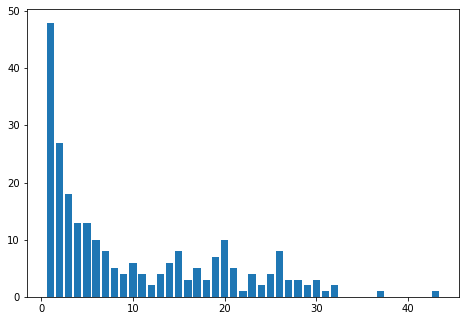

In [60]:
plot_deg_distribution(G)
#plot_deg_distribution(G, weighted=True)

In [61]:
def plot_rank_degree(G, weight=True, xscale = "log", yscale = "log"):

    if (weight):
        rank_degree = [(rank,G.degree(weight='weight')[node]) for node,rank in G.nodes(data='rank')]
    else:
        rank_degree = [(rank,G.degree()[node]) for node,rank in G.nodes(data='rank')]
    rank, degree = zip(*rank_degree)                                                      

    plt.figure(1)   

    # prep axes   
    plt.xlabel('rank')                                                                                                             
    plt.xscale(xscale)                                                                                                                
    plt.xlim(1, max(rank))  

    plt.ylabel('degree')                                                                                                          
    plt.yscale(yscale)                                                                                                                
    plt.ylim(1, max(degree))                                                                                                             
                                                                                                                                                                                                    
    plt.scatter(rank, degree, marker='.')                                                                                                    
    plt.show()

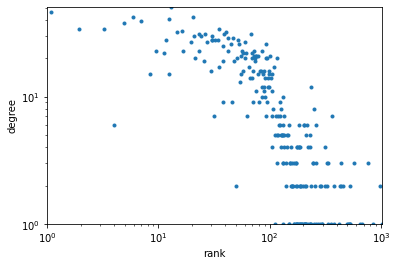

In [62]:
plot_rank_degree(G)

# 18. Da li u mreži postoje habovi i koji su? 

In [63]:
hubs,authorities = nx.hits(G)

high_hubs_players = [(get_player_info(node), h) for node,h in sorted(hubs.items(), key=lambda element: (element[1]),reverse=True)][:10]

high_hubs_players

#moze i eigen_vector

[((126094, 'Andrey Rublev', 13.1, 'RUS'), 0.02230764628030923),
 ((104925, 'Novak Djokovic', 1.08, 'SRB'), 0.022169266851332983),
 ((126774, 'Stefanos Tsitsipas', 5.94, 'GRE'), 0.0215224498069851),
 ((106043, 'Diego Sebastian Schwartzman', 12.36, 'ARG'), 0.01986005675711957),
 ((100644, 'Alexander Zverev', 7.0, 'GER'), 0.019370154981405412),
 ((106421, 'Daniil Medvedev', 4.88, 'RUS'), 0.01832072779662958),
 ((106233, 'Dominic Thiem', 3.22, 'AUT'), 0.017484862500912537),
 ((104745, 'Rafael Nadal', 1.92, 'ESP'), 0.016661522928051568),
 ((200000, 'Felix Auger Aliassime', 20.5, 'CAN'), 0.016464926594477555),
 ((133430, 'Denis Shapovalov', 14.64, 'CAN'), 0.013863012250981094)]

# 19. Da li mreža tenisera iskazuje osobine malog sveta?
A small world network is characterized by a small average shortest path length, and a large clustering coefficient.

Small-worldness is commonly measured with the coefficient sigma or omega.

Both coefficients compare the average clustering coefficient and shortest path length of a given graph against the same quantities for an equivalent random or lattice graph.

In [64]:
# #sigma>1
# sigma = nx.sigma(G)

# #~0
# omega = nx.omega(G)

# 20. Kakve su karakteristike ego mreža članova Velike trojke? U kojoj meri se te karakteristike razlikuju?

In [65]:
def get_average_ranks(G):
    ranks = [rank for node,rank in G.nodes(data='rank')]
    return sum(ranks)/len(ranks)

In [66]:
novak_id = get_player_by_name("Novak Djokovic")
rafa_id = get_player_by_name("Rafael Nadal")
federer_id = get_player_by_name("Roger Federer")

novak_ego_graph = nx.ego_graph(G,novak_id)
print(f"Novakova ego mreza : {nx.info(novak_ego_graph)}")
print(f"Prosecan tezinski stepen : {get_average_weighted_degree(novak_ego_graph)}")
print(f"Gustina mreze : {nx.density(novak_ego_graph)}")
print(f"Prosecan rank tenisera mreze : {get_average_ranks(novak_ego_graph)}")
novak_degree_centrality = [centrality for node, centrality in nx.degree_centrality(novak_ego_graph).items() if node==novak_id]
novak_eigenvector_centrality = [centrality for node, centrality in nx.eigenvector_centrality(novak_ego_graph).items() if node==novak_id]
print(f"Degree centrality : {novak_degree_centrality}")
print(f"Eigenvector centrality : {novak_eigenvector_centrality}")
print("\n")

rafa_ego_graph = nx.ego_graph(G,rafa_id)
print(f"Nadalova ego mreza : {nx.info(rafa_ego_graph)}")
print(f"Prosecan tezinski stepen : {get_average_weighted_degree(rafa_ego_graph)}")
print(f"Gustina mreze : {nx.density(rafa_ego_graph)}")
print(f"Prosecan rank tenisera mreze : {get_average_ranks(rafa_ego_graph)}")
rafa_degree_centrality = [centrality for node, centrality in nx.degree_centrality(rafa_ego_graph).items() if node==rafa_id]
rafa_eigenvector_centrality = [centrality for node, centrality in nx.eigenvector_centrality(rafa_ego_graph).items() if node==rafa_id]
print(f"Degree centrality : {rafa_degree_centrality}")
print(f"Eigenvector centrality : {rafa_eigenvector_centrality}")
print("\n")

federer_ego_graph = nx.ego_graph(G,federer_id)
print(f"Federerova ego mreza : {nx.info(federer_ego_graph)}")
print(f"Prosecan tezinski stepen : {get_average_weighted_degree(federer_ego_graph)}")
print(f"Gustina mreze : {nx.density(federer_ego_graph)}")
print(f"Prosecan rank tenisera mreze : {get_average_ranks(federer_ego_graph)}")
federer_degree_centrality = [centrality for node, centrality in nx.degree_centrality(federer_ego_graph).items() if node==federer_id]
federer_eigenvector_centrality = [centrality for node, centrality in nx.eigenvector_centrality(federer_ego_graph).items() if node==federer_id]
print(f"Degree centrality : {federer_degree_centrality}")
print(f"Eigenvector centrality : {federer_eigenvector_centrality}")

Novakova ego mreza : Name: 
Type: Graph
Number of nodes: 33
Number of edges: 117
Average degree:   7.0909
Prosecan tezinski stepen : 9.030303030303031
Gustina mreze : 0.2215909090909091
Prosecan rank tenisera mreze : 51.02787878787879
Degree centrality : [1.0]
Eigenvector centrality : [0.4633028683244207]


Nadalova ego mreza : Name: 
Type: Graph
Number of nodes: 30
Number of edges: 104
Average degree:   6.9333
Prosecan tezinski stepen : 8.8
Gustina mreze : 0.23908045977011494
Prosecan rank tenisera mreze : 49.851333333333336
Degree centrality : [1.0]
Eigenvector centrality : [0.4647269141556679]


Federerova ego mreza : Name: 
Type: Graph
Number of nodes: 7
Number of edges: 11
Average degree:   3.1429
Prosecan tezinski stepen : 3.4285714285714284
Gustina mreze : 0.5238095238095238
Prosecan rank tenisera mreze : 39.35714285714285
Degree centrality : [1.0]
Eigenvector centrality : [0.548427463361397]


In [67]:
novak_nodes = set(novak_ego_graph.nodes())
rafa_nodes = set(rafa_ego_graph.nodes())
federer_nodes = set(federer_ego_graph.nodes())

novak_rafa_node = novak_nodes.intersection(rafa_nodes)
novak_federer_node = novak_nodes.intersection(federer_nodes)
rafa_federer_node = rafa_nodes.intersection(federer_nodes)

print(f"Novak i Rafa: {len(novak_rafa_node)}")
print(f" {get_players_info(novak_rafa_node)}")
print("\n")
print(f"Novak i Federer: {len(novak_federer_node)}")
print(f" {get_players_info(novak_federer_node)}")
print("\n")
print(f"Federer i Rafa: {len(rafa_federer_node)}")
print(f" {get_players_info(rafa_federer_node)}")

Novak i Rafa: 9
 [(100644, 'Alexander Zverev', 7.0, 'GER'), (104745, 'Rafael Nadal', 1.92, 'ESP'), (106415, 'Yoshihito Nishioka', 52.5, 'JPN'), (105807, 'Pablo Carreno Busta', 23.24, 'ESP'), (106421, 'Daniil Medvedev', 4.88, 'RUS'), (126774, 'Stefanos Tsitsipas', 5.94, 'GRE'), (106233, 'Dominic Thiem', 3.22, 'AUT'), (106043, 'Diego Sebastian Schwartzman', 12.36, 'ARG'), (104925, 'Novak Djokovic', 1.08, 'SRB')]


Novak i Federer: 4
 [(105936, 'Filip Krajinovic', 32.34, 'SRB'), (103819, 'Roger Federer', 3.96, 'SUI'), (104925, 'Novak Djokovic', 1.08, 'SRB'), (105815, 'Tennys Sandgren', 55.82, 'USA')]


Federer i Rafa: 1
 [(104925, 'Novak Djokovic', 1.08, 'SRB')]


# 21. Kakva je pozicija ego čvora u svakoj od ego mreža? Kako su oni strukturno ugrađeni u mrežu?

In [68]:
novak_edges = [edge for edge in novak_ego_graph.edges(nbunch=novak_id)]
edges = novak_ego_graph.edges()

print(f"Procenat Novakovih veza = {len(novak_edges)*100/len(edges)}")

rafa_edges = [edge for edge in rafa_ego_graph.edges(nbunch=rafa_id)]
edges = rafa_ego_graph.edges()

print(f"Procenat Nadalovih veza = {len(rafa_edges)*100/len(edges)}")

federer_edges = [edge for edge in federer_ego_graph.edges(nbunch=federer_id)]
edges = novak_ego_graph.edges()

print(f"Procenat Federerovih veza = {len(federer_edges)*100/len(edges)}")

Procenat Novakovih veza = 27.35042735042735
Procenat Nadalovih veza = 27.884615384615383
Procenat Federerovih veza = 5.128205128205129


# 22. Kako su posmatrane ego mreže ugrađene u mrežu tenisera?

In [69]:
novak_ego_edges = [edge for edge in novak_ego_graph.edges()]
edges = [edge for edge in G.edges()]

print(f"Procenat Novakovih veza u ego i obicnoj mrezi = {len(novak_ego_edges)*100/len(edges)}")
print(f"Procenat Novakovih suparnika u obicnoj mrezi = {len(novak_nodes)*100/len(G.nodes())}")

Procenat Novakovih veza u ego i obicnoj mrezi = 9.62171052631579
Procenat Novakovih suparnika u obicnoj mrezi = 13.524590163934427


In [70]:
rafa_ego_edges = [edge for edge in rafa_ego_graph.edges()]
edges = [edge for edge in G.edges()]

print(f"Procenat Nadalovih veza u ego i obicnoj mrezi = {len(rafa_ego_edges)*100/len(edges)}")
print(f"Procenat Nadalovih suparnika u obicnoj mrezi = {len(rafa_nodes)*100/len(G.nodes())}")

Procenat Nadalovih veza u ego i obicnoj mrezi = 8.552631578947368
Procenat Nadalovih suparnika u obicnoj mrezi = 12.295081967213115


In [71]:
federer_ego_edges = [edge for edge in federer_ego_graph.edges()]
edges = [edge for edge in G.edges()]

print(f"Procenat Federerovih veza u ego i obicnoj mrezi = {len(federer_ego_edges)*100/len(edges)}")
print(f"Procenat Federerovih suparnika u obicnoj mrezi = {len(federer_nodes)*100/len(G.nodes())}")

Procenat Federerovih veza u ego i obicnoj mrezi = 0.9046052631578947
Procenat Federerovih suparnika u obicnoj mrezi = 2.8688524590163933


# 23. Analizirati mrežu dobijenu unifikacijom ego mreža članova Velike trojke.
## Koji procenat čvorova mreže svih tenisera učestvuje u njoj?
## Sprovesti klasterisanje ovako dobijene mreže na tri klastera i na osnovu dobijenih rezultata dati interpretaciju kriterijuma pripadnosti klasterima.


In [72]:
all_edges = set(novak_ego_edges).union(set(rafa_ego_edges)).union(set(federer_ego_edges))

u = G.edge_subgraph(all_edges)
print(f"Unificirana mreza : {nx.info(u)}")
print(f"Prosecan tezinski stepen : {get_average_weighted_degree(u)}")
print(f"Gustina mreze : {nx.density(u)}")
print(f"Prosecan rank tenisera mreze : {get_average_ranks(u)}")

Unificirana mreza : Name: 
Type: Graph
Number of nodes: 57
Number of edges: 202
Average degree:   7.0877
Prosecan tezinski stepen : 8.56140350877193
Gustina mreze : 0.12656641604010024
Prosecan rank tenisera mreze : 57.01087719298243


In [73]:
print(f"Procenat cvorova u unificirano mrezi = {len(u.nodes())*100/len(G.nodes())}")

Procenat cvorova u unificirano mrezi = 23.360655737704917


In [74]:
data = u.nodes()
edge_mat = nx.to_numpy_matrix(u,nodelist=data,weight='weight')

kmeans = cluster.KMeans(n_clusters=3, n_init=200)

kmeans = kmeans.fit(edge_mat)

#initialize dict
clusters = {}
for index in range(0,3): 
    nodes = []    
    clusters[index] = nodes
    
for cluster_info in zip(data,kmeans.labels_):
    clusters[cluster_info[1]].append(cluster_info[0])
clusters

{0: [100644, 104745, 106421, 126774, 106043, 105807, 106233],
 1: [106378,
  103819,
  105357,
  126094,
  106000,
  105882,
  104731,
  106401,
  105643,
  103852,
  106415,
  200624,
  105777,
  105138,
  105526,
  133430,
  106426,
  132283,
  105916,
  105147,
  106432,
  144707,
  104259,
  105676,
  105932,
  105936,
  104655,
  111442,
  105683,
  106198,
  105815,
  104792,
  111575,
  200282,
  104665,
  206173,
  106078,
  111456,
  104291,
  105575,
  126952,
  105449,
  123755,
  105583,
  200175,
  134770,
  106099,
  136440,
  126203],
 2: [104925]}

In [75]:
N = len(u.nodes())

num_of_ego_graphs = {}
for node in u.nodes():
    n = 1 if node in novak_ego_graph else 0
    r = 1 if node in rafa_ego_graph else 0
    f = 1 if node in federer_ego_graph else 0
    num_of_ego_graphs[node] = n+r+f

edge_matrix =  np.array([[0 for i in range(2)]] * N )
node_index = 0
for node in u.nodes():
    for neighbor in u.neighbors(node):
        neighbor_index = list(u.nodes()).index(neighbor)
        edge_matrix[node_index,1] = num_of_ego_graphs[node]
    node_index+=1
        
edge_matrix

array([[0, 1],
       [0, 2],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 2],
       [0, 2],
       [0, 1],
       [0, 1],
       [0, 2],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 2],
       [0, 2],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 2],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 2],
       [0, 2],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 2],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 3],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 2],
       [0, 1]])

In [76]:
kmeans = cluster.KMeans(n_clusters=3, n_init=200)

kmeans = kmeans.fit(edge_matrix)

#initialize dict
big_three_clusters = {}
for index in range(0,3): 
    nodes = []    
    big_three_clusters[index] = nodes
    
for cluster_info in zip(data,kmeans.labels_):
    big_three_clusters[cluster_info[1]].append(cluster_info[0])
big_three_clusters

{0: [106378,
  105357,
  126094,
  106000,
  105882,
  104731,
  106401,
  105643,
  103852,
  200624,
  105777,
  105138,
  105526,
  133430,
  106426,
  132283,
  105916,
  105147,
  106432,
  144707,
  104259,
  105676,
  105932,
  104655,
  111442,
  105683,
  106198,
  104792,
  111575,
  200282,
  104665,
  206173,
  106078,
  111456,
  104291,
  105575,
  126952,
  105449,
  123755,
  105583,
  200175,
  134770,
  106099,
  136440,
  126203],
 1: [103819,
  100644,
  104745,
  106415,
  106421,
  126774,
  106043,
  105807,
  105936,
  105815,
  106233],
 2: [104925]}

In [77]:
def get_players_cluster(id):
    for cluster_index in range(0,3):
        if id in clusters[cluster_index]:
            return cluster_index

In [78]:
get_players_cluster(novak_id)

2

In [79]:
get_players_cluster(rafa_id)

0

In [80]:
get_players_cluster(federer_id)

1

# 24. Kakva je distribucija broja tenisera u odnosu na broj mečeva koji su odigrali?

Counter({1: 48, 2: 27, 3: 18, 4: 13, 5: 12, 6: 10, 7: 9, 20: 8, 16: 7, 23: 7, 15: 7, 28: 6, 21: 6, 9: 6, 14: 5, 12: 5, 22: 4, 31: 4, 19: 4, 17: 3, 30: 3, 26: 3, 11: 3, 27: 3, 34: 3, 10: 3, 8: 3, 32: 2, 42: 2, 29: 2, 51: 1, 39: 1, 46: 1, 41: 1, 25: 1, 13: 1, 38: 1, 33: 1})


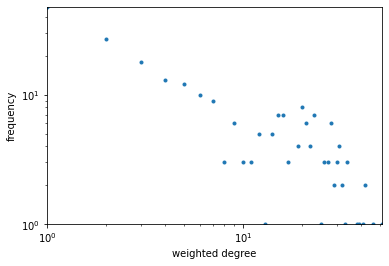

In [81]:
plot_deg_frequency(G, weighted = True)

# 25. Kakva je distribucija broja turnira u odnosu na podlogu i godinu održavanja?

In [82]:
def plot_tourney_per_surface_frequency(G, xscale = "linear", yscale = "linear"):

    surfaces = [surface for node,surface in G.nodes(data='surface')]
    surfaces_counts = Counter(surfaces) #prebrojava, 1, 2, ..        
    print(surfaces_counts)
    surface, num_of_tourneys = zip(*surfaces_counts.items())                                                      

    fig = plt.figure(1)   
    plt.ylabel('num of tourneys')
    ax = fig.add_axes([0,0,1,1])
    ax.bar(surface,num_of_tourneys)
    plt.show()

Counter({'Hard': 24, 'Clay': 9})


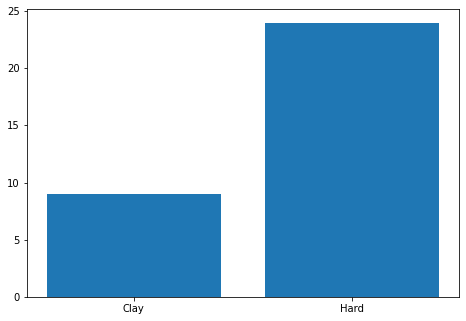

In [83]:
tourney_sub_graph = tourney_graph.subgraph(tourney_nodes)

plot_tourney_per_surface_frequency(tourney_sub_graph)

# 26. Kakva je distribucija broja mečeva u odnosu na podlogu i godinu održavanja?

In [84]:
def plot_matches_per_surface_frequency(G, xscale = "linear", yscale = "linear"):

    data = [(surface,int((tourney_graph.degree(node,weight="weight"))/2)) for node,surface in tourney_graph.nodes(data='surface') if  node in tourney_names]

    dictionary = dict()
    for (surface, val) in data: 
        dictionary[surface] = dictionary.get(surface, 0) + val  # return the value for that key or return default 0 (and create key)
    surface=list(dictionary.keys())
    num_of_matches=list(dictionary.values())
    print(dictionary)

    fig = plt.figure(1)   
  
    ax = fig.add_axes([0,0,1,1])
    ax.bar(surface,num_of_matches)
    plt.show()

{'Hard': 960, 'Clay': 378}


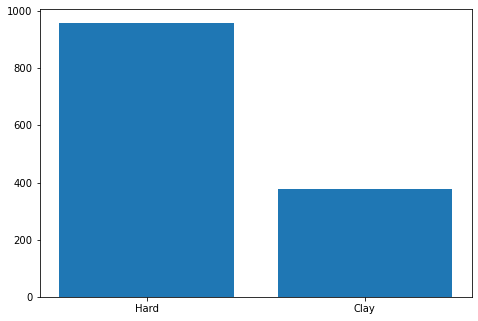

In [85]:
plot_matches_per_surface_frequency(tourney_graph)

#u proseku na svakom turniru po 40 meceva

# Cuvanje grafa

In [86]:
nx.write_gexf(G,output_gz_path)

# Vizuelizacija

In [87]:
def get_gephi_rank_group(rank):
    if rank<10:
        return 'group10'
    if rank<20:
        return 'group20'
    if rank<50:
        return 'group50'
    if rank<100:
        return 'group100'
    if rank<250:
        return 'group250'
    if rank<500:
        return 'group500'
    if rank<2000:
        return 'group2000'
    return 'group2000'

def add_gephi_rank_group_attribute(G):
    for player in G.nodes:
        G.nodes[player]['rank_group']=get_gephi_rank_group(G.nodes[player]['rank'])
        
def reverse_rank(G):
    for player in G.nodes:
        rank = G.nodes[player]['rank']
        G.nodes[player]['rank']=-rank if not np.isnan(rank) else -float(2000)

def set_ego_node_attribute(G,ego_nodes,ego_type):  
    for player in G.nodes:
        G.nodes[player]['node_type']=ego_type if player in ego_nodes else 'not_ego_node'
        
def set_ego_edge_attribute(G,ego_edges,ego_type):         
    for (source,target) in G.edges:
        G.edges[source,target]['edge_type']=ego_type if (((source,target) in ego_edges) | ((target,source) in ego_edges)) else 'not_ego_edge'          
        
def set_ego_attribute(G,ego_nodes,ego_edges,ego_type):  
    set_ego_node_attribute(G,ego_nodes,ego_type)
    set_ego_edge_attribute(G,ego_edges,ego_type)

def set_community_attribute(G):
    for key, values in communities_info.items():
        for value in values:
            G.nodes[value[0]]['community'] = key

def set_cluster_attribute(G):
    for key, values in clusters.items():
        for value in values:
            G.nodes[value]['cluster'] = key
    # hocu da mi se u gephi-ju prikazuje label samo za ovu trojicu pa cu to ovako da uradim
    for player in G.nodes():
        G.nodes[player]['help_label'] = G.nodes[player]['player_name'] if G.nodes[player]['player_name'] in ['Novak Djokovic', 'Rafael Nadal', 'Roger Federer'] else ''
        
def set_big_three_clusters_attribute(G):
    for key, values in big_three_clusters.items():
        for value in values:
            G.nodes[value]['big_three_clusters'] = key
    # hocu da mi se u gephi-ju prikazuje label samo za ovu trojicu pa cu to ovako da uradim
    for player in G.nodes():
        G.nodes[player]['help_label'] = G.nodes[player]['player_name'] if G.nodes[player]['player_name'] in ['Novak Djokovic', 'Rafael Nadal', 'Roger Federer'] else ''
 

In [88]:
def relable(G):
    values = [name for node,name in G.nodes(data='player_name')]
    mapping  = dict(zip(G, values))

    return  nx.relabel_nodes(G, mapping)   

def arrange_graph(G):
    H = copy.deepcopy(G)

    add_gephi_rank_group_attribute(H)
    
    reverse_rank(H)    
    return relable(H)

def arrange_ego_in_graph(G,nodes,edges,node_type):
    H = copy.deepcopy(G)
    
    set_ego_attribute(H,nodes,edges,node_type)
    reverse_rank(H) 
    return relable(H)

def arrange_ego_graph(G,edges,node_type):
    H = copy.deepcopy(G)
    
    set_ego_edge_attribute(H,edges,node_type)
    reverse_rank(H) 
    return relable(H)

def arrange_communities(G):
    H = copy.deepcopy(G)
    
    set_community_attribute(H)
    add_gephi_rank_group_attribute(H)
    reverse_rank(H)
    return relable(H)

def arrange_clusters(G):
    H = copy.deepcopy(G)
    
    set_cluster_attribute(H)
    add_gephi_rank_group_attribute(H)
    reverse_rank(H)
    return relable(H)

def arrange_big_three_clusters(G):
    H = copy.deepcopy(G)
    
    set_big_three_clusters_attribute(H)
    add_gephi_rank_group_attribute(H)
    reverse_rank(H)
    return relable(H)

In [90]:
nx.write_gml(arrange_graph(G), output_gml_path)

nx.write_gml(arrange_ego_in_graph(G,novak_nodes,novak_ego_edges,'novak'), "novak_ego_in_2020.gml")
nx.write_gml(arrange_ego_in_graph(G,rafa_nodes,rafa_ego_edges,'rafa'), "rafa_ego_in_2020.gml")
nx.write_gml(arrange_ego_in_graph(G,federer_nodes,federer_ego_edges,'federer'), "federer_ego_in_2020.gml")

nx.write_gml(arrange_ego_graph(novak_ego_graph,novak_edges,'novak'), "novak_ego_graph_2020.gml")
nx.write_gml(arrange_ego_graph(rafa_ego_graph,rafa_edges,'rafa'), "rafa_ego_graph_2020.gml")
nx.write_gml(arrange_ego_graph(federer_ego_graph,federer_edges,'federer'), "federer_ego_graph_2020.gml")

nx.write_gml(arrange_communities(G), "communities_2020.gml")
nx.write_gml(arrange_clusters(u), "clusters_unified_graph_2020.gml")

#asyn_fluid_clusters
#nx.write_gml(arrange_asyn_fluid_clusters(u), "asyn_fluid_clusters_unified_graph_2020.gml")

nx.write_gml(arrange_big_three_clusters(u), "big_three_clusters_unified_graph_2020.gml")